### One in One out Spline Network

In [142]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class TriangularCell(nn.Module):
    ### 使用中心和宽度定义三角形单元，
    # 其中中心是三角形的顶点，
    # 宽度是三角形的底边长的一半
    def __init__(self, shift, width):
        super(TriangularCell, self).__init__()
        self.shift = shift
        self.width = width
        self.weight = nn.Parameter(torch.ones(1))

    def forward(self, x):
        return self.weight * torch.relu(1 - torch.abs((x - self.shift) / self.width))

class Net(nn.Module):
    ### 通过将多个三角形单元串联在一起来定义网络，每个单元的中心和宽度都不同
    def __init__(self, num_slices, range_tuple):
        ### num_slices: 切分的数量
        ### width: 三角形的宽度，
        super(Net, self).__init__()
        self.num_cells = num_slices
        self.width = (range_tuple[1] - range_tuple[0]) / (num_slices - 1)
        self.left = range_tuple[0]
        self.right = range_tuple[1]

        self.cells = nn.ModuleList([
            TriangularCell( self.left + self.width * n  , self.width ) for n in range(num_slices)
        ])

    def forward(self, x):
        output = torch.zeros_like(x)
        for cell in self.cells:
            output += cell(x)
        return output



epoch: 0, loss: 1.476998209953308
epoch: 100, loss: 0.3267437815666199
epoch: 200, loss: 0.05502627044916153
epoch: 300, loss: 0.007001686375588179
epoch: 400, loss: 0.0008319995831698179
epoch: 500, loss: 0.000224885341594927
epoch: 600, loss: 0.00017352678696624935
epoch: 700, loss: 0.00016895128646865487
epoch: 800, loss: 0.00016843710909597576
epoch: 900, loss: 0.00016836801660247147


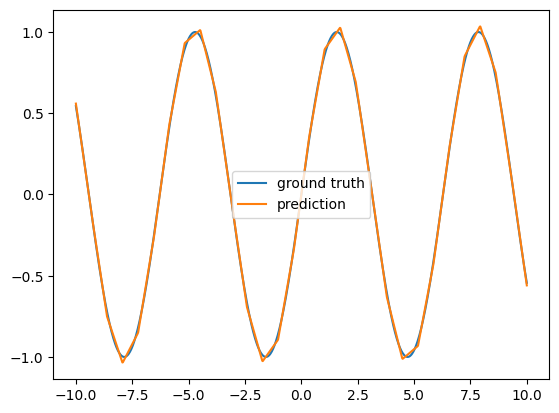

In [151]:
# 训练一个简单的网络
# 数据集
x = np.linspace(-10, 10, 1000)
y = np.sin(x)

# 定义网络
net = Net(30, (-10, 10))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

# 训练
for epoch in range(1000):
    optimizer.zero_grad()
    output = net(torch.tensor(x).float())
    loss = criterion(output, torch.tensor(y).float())
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'epoch: {epoch}, loss: {loss.item()}')

# 可视化
plt.plot(x, y, label='ground truth')
plt.plot(x, output.detach().numpy(), label='prediction')
plt.legend()
plt.show()



### m in one out Spline Network

In [209]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class TriangularCell(nn.Module):
    ### 使用中心和宽度定义三角形单元，
    # 其中中心是三角形的顶点，
    # 宽度是三角形的底边长的一半
    def __init__(self, shift, width):
        super(TriangularCell, self).__init__()
        self.shift = shift
        self.width = width
        self.weight = nn.Parameter(torch.ones(1))

    def forward(self, x):
        return self.weight * torch.relu(1 - torch.abs((x - self.shift) / self.width))

class Net(nn.Module):
    ### 通过将多个三角形单元串联在一起来定义网络，每个单元的中心和宽度都不同
    def __init__(self, num_slices, range_tuple):
        ### num_slices: 切分的数量
        ### width: 三角形的宽度，
        super(Net, self).__init__()
        self.num_cells = num_slices
        self.width = (range_tuple[1] - range_tuple[0]) / (num_slices - 1)
        self.left = range_tuple[0]
        self.right = range_tuple[1]

        self.cells = nn.ModuleList([
            TriangularCell( self.left + self.width * n  , self.width ) for n in range(num_slices)
        ])

    def forward(self, x):
        output = torch.zeros_like(x)
        for cell in self.cells:
            output += cell(x)
        return output

class ConvNet(nn.Module):
    ### 输入 m个数据，输出1个数据
    ### 先对m个数据进行卷积，再使用一个三角形的网络
    def __init__(self, num_slices, range_tuple, kernal_size):

        super(ConvNet, self).__init__()
        self.conv = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=kernal_size, stride=1, padding="same")
        self.net = Net(num_slices, range_tuple)
    
    def forward(self, x):
        x = x.unsqueeze(0)
        x = self.conv(x)
        x = x.squeeze(0).squeeze(0)
        return self.net(x)
    


epoch: 0, loss: 1.5857950448989868
epoch: 100, loss: 0.1690262109041214
epoch: 200, loss: 0.0003427466144785285
epoch: 300, loss: 0.00010222965647699311
epoch: 400, loss: 7.148063014028594e-05
epoch: 500, loss: 6.047535134712234e-05
epoch: 600, loss: 5.582500307355076e-05
epoch: 700, loss: 5.3637286328012124e-05
epoch: 800, loss: 5.199320730753243e-05
epoch: 900, loss: 5.044922363595106e-05


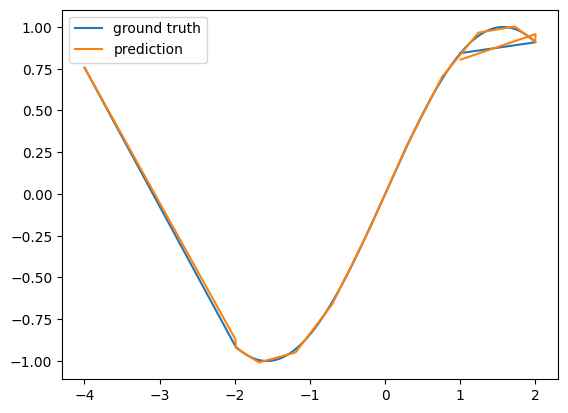

In [210]:
### 训练一个简单的网络
# 数据集
x = np.linspace(-10, 10, 1000)
### x以 0.1， 0.3， -0.2 进行卷积
x = np.convolve(x, [0.1, 0.3, -0.2], 'same')

### y 变为sin
y = np.sin(x)

# 定义网络
net = ConvNet(num_slices= 30, range_tuple=(-10, 10), kernal_size=3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

# 训练
for epoch in range(1000):
    optimizer.zero_grad()
    output = net(torch.tensor(x).float())
    loss = criterion(output, torch.tensor(y).float())
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'epoch: {epoch}, loss: {loss.item()}')

# 可视化
plt.plot(x, y, label='ground truth')
plt.plot(x, output.detach().numpy(), label='prediction')
plt.legend()
plt.show()



In [204]:
y.shape

(998,)